In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import random
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})
import pandas as pd
import numpy as np
import scipy.interpolate
from scipy.interpolate import interp1d
from src.utils.Notebook_imports import *
from src.data.Preprocess import clip_quantile

from ipywidgets import interact
import ipywidgets as widgets
from IPython.core.display import display, HTML
%matplotlib inline
%reload_ext autoreload
%autoreload 2

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models


## 0.1 Link to medical definition of the cardiac function

[source](https://next.amboss.com/de/article/xL0E-g)

Systole
1.) Anspannungsphase

    Hauptfunktion: Ventrikel kontrahieren sich
    Ablauf
        Alle Klappen sind geschlossen und die Ventrikel sind mit Blut gefüllt
        Isovolumetrische Kontraktion des Arbeitsmyokards 

    Druckanstieg in den Ventrikeln, bis der Druck in der Aorta bzw. dem Truncus pulmonalis überschritten ist
    Passive Öffnung der Taschenklappen (Pulmonal- und Aortenklappe) → Beginn der Austreibungsphase

Status des linken Ventrikels

    Druck: Anstieg von ca. 8 mmHg auf ca. 80 mmHg 

Volumen: Gleichbleibend ca. 150 mL (isovolumetrische Anspannung)
2.) Austreibungsphase

    Hauptfunktion: Blut wird aus Ventrikeln in Kreislauf und Lunge gepumpt
    Ablauf
        Blut strömt aus den Ventrikeln in den Truncus pulmonalis bzw. die Aorta (Großteil bereits zu Beginn der Austreibungsphase)
        Weitere Kontraktion des Myokards (beginnend am distalen Septum und der Herzspitze)
        Wanddicke der Ventrikel ↑ und Innendurchmesser der Ventrikel ↓
        Druck in den Ventrikeln ↑ (Laplace-Gesetz) → Blutvolumen ↓ im Ventrikel
        Druck ↓ langsam im Ventrikel (bis unter den Druck der Aorta bzw. Truncus pulmonalis)
        Schluss der Taschenklappen → Beginn der Entspannungsphase
    Status des linken Ventrikels
        Druck: Anstieg von ca. 80 mmHg auf ca. 120 mmHg, danach Absinken 

Volumen: Austreibung von ca. 90 mL Schlagvolumen (150 mL → 60 mL)
Diastole
3.) Entspannungsphase

    Hauptfunktion: Ventrikel entspannen sich
    Ablauf
        Alle Herzklappen sind geschlossen (Volumen bleibt konstant)
        Weitere Entspannung des Myokards (Druck ↓ in den Ventrikeln)
        Isovolumetrische Entspannung
        Ventrikeldruck fällt unter den Druck in den Vorhöfen
        Segelklappen öffnen sich → Beginn der Füllungsphase
    Status des linken Ventrikels
        Druck: Absinken auf ca. 10 mmHg 

Volumen: Gleichbleibend ca. 60 mL (isovolumetrische Entspannung)
4.) Füllungsphase

    Hauptfunktion: Ventrikel füllen sich erneut mit Blut
    Ablauf
        Die Ventilebene hebt sich und "stülpt" sich über die Blutsäule in den Vorhöfen (Ventilebenenmechanismus)
        Am Ende der Diastole kontrahieren die Vorhöfe kurz
        Druck im Ventrikel übersteigt den Druck der Vorhöfe
        Schluss Segelklappen → Beginn der Anspannungsphase
    Status des linken Ventrikels
        Druck: ca. 8 mmHg 

Volumen: Füllung mit ca. 90 mL (60 mL → 150 mL)

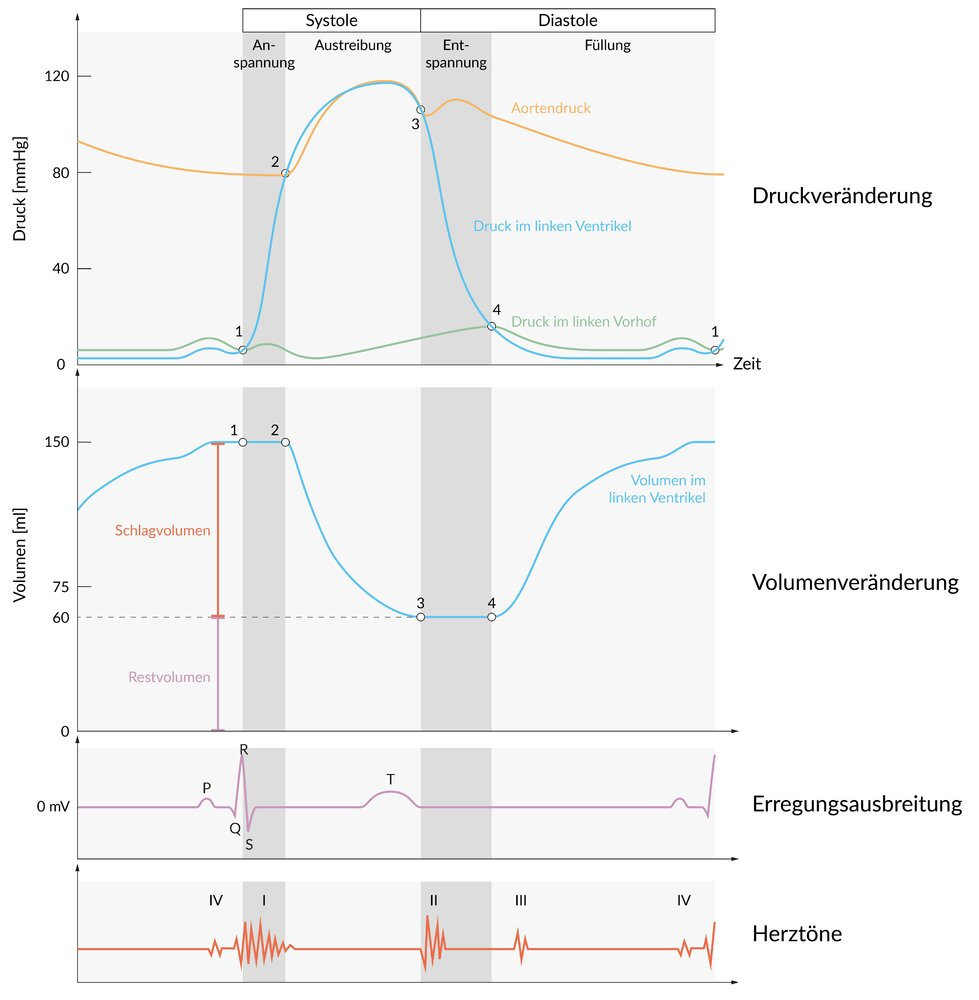

In [2]:
from IPython import display as disp
disp.Image("https://media-de.amboss.com/media/thumbs/big_5f22e89d3edf1.jpg")

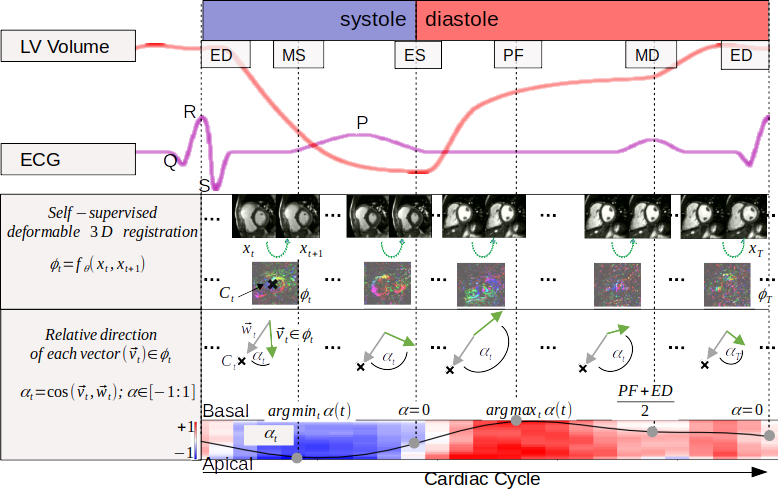

In [3]:
# mapping between the 5 defined cardiac phases and the lv volume curve
disp.Image("notebooks/Dataset/overview.png")

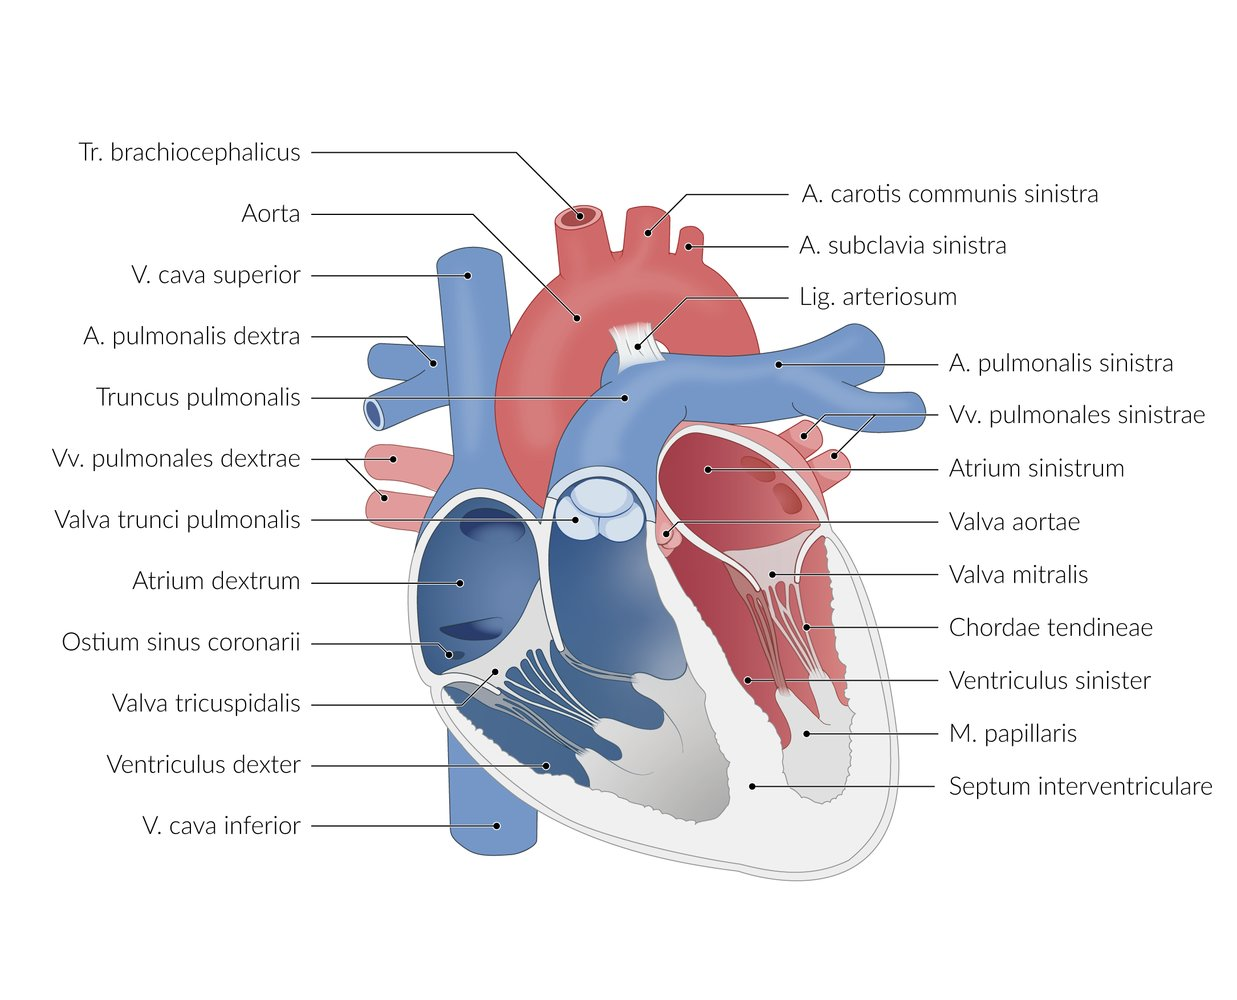

In [4]:
disp.Image("https://media-de.amboss.com/media/thumbs/big_5e147f74d36fe.jpg")

# 1. Load phase-vector and gt/pred from a project

In [5]:
from ipyfilechooser import FileChooser
vects_chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/'), '')
display(vects_chooser)

FileChooser(path='/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc', filename='', title='HTML(value='', la…

In [6]:
# load the vectors
temp = '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/roll2lv/phaseloss0_2lstm32_gcn/2022-02-21_19_10/'
#pathstovectnpy = sorted(glob.glob(os.path.join(temp, 'moved', '*vects*.npy')))
pathstovectnpy = sorted(glob.glob(os.path.join(vects_chooser.selected, 'moved', '*vects*.npy')))
print(pathstovectnpy)
nda_vects = np.concatenate([np.load(path_) for path_ in pathstovectnpy],axis=0)
print(nda_vects.shape)

['/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/acdc/center/phaseloss0_2lstm32_acdc/2022-03-03_15_11/moved/vects_f0.npy', '/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/acdc/center/phaseloss0_2lstm32_acdc/2022-03-03_15_11/moved/vects_f1.npy', '/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/acdc/center/phaseloss0_2lstm32_acdc/2022-03-03_15_11/moved/vects_f2.npy', '/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/acdc/center/phaseloss0_2lstm32_acdc/2022-03-03_15_11/moved/vects_f3.npy']
(99, 40, 16, 64, 64, 3)


In [7]:
# load the phase gt and pred

pred_path = os.path.join(vects_chooser.selected, 'pred')
pathtsophasenpy = sorted(glob.glob(os.path.join(pred_path, '*gtpred*.npy')))
print(pathtsophasenpy)
nda_phase = np.concatenate([np.load(path_) for path_ in pathtsophasenpy],axis=1)
print(nda_phase.shape)
gt_, pred_ = np.split(nda_phase, axis=0,indices_or_sections=2)
print(gt_.shape)
gt= gt_[0,:,0]
pred = pred_[0,:,0]
print(gt.shape)
gt_len = gt_[0,:,1]

['/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/acdc/center/phaseloss0_2lstm32_acdc/2022-03-03_15_11/pred/gtpred_fold0.npy', '/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/acdc/center/phaseloss0_2lstm32_acdc/2022-03-03_15_11/pred/gtpred_fold1.npy', '/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/acdc/center/phaseloss0_2lstm32_acdc/2022-03-03_15_11/pred/gtpred_fold2.npy', '/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/acdc/center/phaseloss0_2lstm32_acdc/2022-03-03_15_11/pred/gtpred_fold3.npy']
(2, 99, 2, 40, 5)
(1, 99, 2, 40, 5)
(99, 40, 5)


In [8]:
# load some moved examples for easier understanding of the dimensions
pathtomoved = sorted(glob.glob(os.path.join(vects_chooser.selected, 'moved','*moved*.npy')))
print(len(pathtomoved))
mov = np.concatenate([np.load(path_) for path_ in pathtomoved],axis=0)
print(mov.shape) # patient,time,spatial-z,y,x,channel, e.g.: 69,40,16,64,64,1

4
(99, 40, 16, 64, 64, 1)


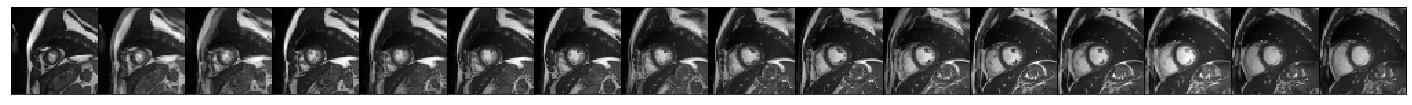

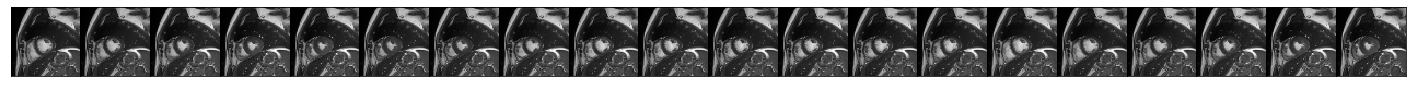

In [9]:
# plot one moved timestep of one patient = one 3D volume 
# should go from apex to base
from src.visualization.Visualize import show_2D_or_3D
example = 15
# apex to base one t
t0_moved = mov[example,0,...,0]
_ = show_2D_or_3D(t0_moved, cmap='gray', interpolation='none')
# one slice over time
z8_moved = mov[example,:,8,...,0]
_ = show_2D_or_3D(z8_moved, cmap='gray', interpolation='none')

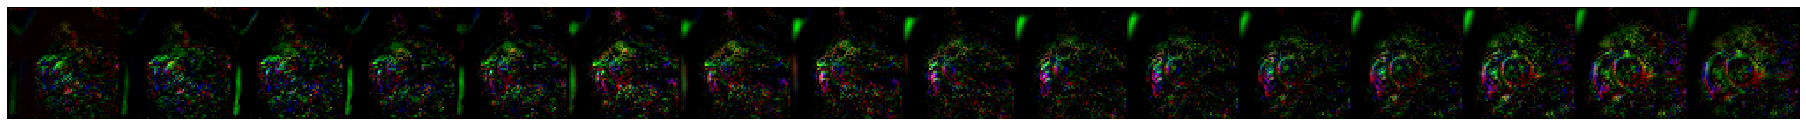

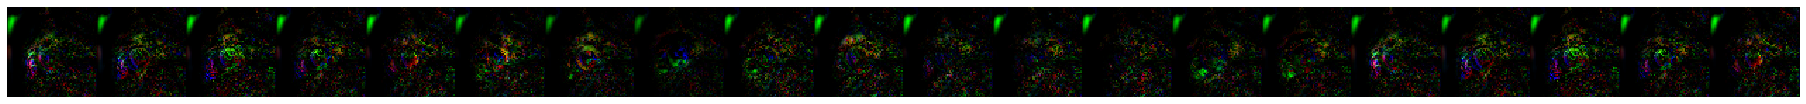

In [10]:
t0_vect = nda_vects[example,0,...]
_ = show_2D_or_3D(t0_vect, interpolation='none')
z8_vect = nda_vects[example,:,8,...]
_ = show_2D_or_3D(z8_vect, interpolation='none')

# 2. Import / define some helper functions

In [11]:
import tensorflow as tf
import sys
# returns a matrix with the indicies as values, similar to np.indicies
def get_idxs_tf(x):
    return tf.cast(
        tf.reshape(tf.where(tf.ones((x[0], x[1], x[2]))), (x[0], x[1], x[2], 3)),
        tf.float32)


# returns a matrix with vectors pointing to the center
def get_centers_tf(x):
    return tf.cast(
        tf.tile(tf.convert_to_tensor([x[0] // 2, x[1] // 2, x[2] // 2])[tf.newaxis, tf.newaxis, tf.newaxis, ...],
                (x[0], x[1], x[2], 1)), tf.float32)

def get_angle_np(a, b):
    # this should work for batches of n-dimensional vectors
    # α = arccos[(a · b) / (|a| * |b|)]
    # |v| = √(x² + y² + z²)
    """
    in 3D space
    If vectors a = [xa, ya, za], b = [xb, yb, zb], then:
    α = arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]
    """
    import math as m
    #pi = tf.constant(m.pi)
    #b = np.cast(b, dtype=a.dtype)
    inner = np.einsum('...i,...i->...', a, b)
    norms = np.linalg.norm(a, axis=-1) * np.linalg.norm(b, axis=-1)  # [...,None]
    cos = inner / (norms + sys.float_info.epsilon)
    #rad = tf.math.acos(tf.clip_by_value(cos, -1.0, 1.0))
    # rad2deg conversion
    #deg = rad * (180.0/pi)
    return cos[..., np.newaxis]

def get_angle_tf(a, b):
    # this should work for batches of n-dimensional vectors
    # α = arccos[(a · b) / (|a| * |b|)]
    # |v| = √(x² + y² + z²)
    """
    in 3D space
    If vectors a = [xa, ya, za], b = [xb, yb, zb], then:
    α = arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]
    """
    import math as m
    pi = tf.constant(m.pi)
    b = tf.cast(b, dtype=a.dtype)
    inner = tf.einsum('...i,...i->...', a, b)
    norms = tf.norm(a, ord='euclidean', axis=-1) * tf.norm(b, ord='euclidean', axis=-1)  # [...,None]
    cos = inner / (norms + sys.float_info.epsilon)
    #rad = tf.math.acos(tf.clip_by_value(cos, -1.0, 1.0))
    # rad2deg conversion
    #deg = rad * (180.0/pi)
    return cos[..., tf.newaxis]
import sys
dim = np.array([16,64,64])
idx = get_idxs_tf(dim)
c = get_centers_tf(dim)
centers = c - idx
centers_tensor = centers[tf.newaxis, ...]
flow2direction_lambda = tf.keras.layers.Lambda(
            lambda x: get_angle_tf(x, centers_tensor), name='flow2direction')
minmax_lambda = lambda x : x[1] + (((x[0] - np.min(x[0])) * (x[2]-x[1]))/(np.max(x[0]) - np.min(x[0]) + sys.float_info.epsilon))
# define some central params
lower, mid, upper = -1,0, 1

In [12]:
# returns a matrix with vectors pointing to the focus point C
def get_focus_tf(p,dim=[12,12,12]):
    return tf.cast(
        tf.tile(tf.convert_to_tensor([*p])[tf.newaxis, tf.newaxis, tf.newaxis, ...],
                (*dim, 1)), tf.float32)

flow2direction_lambda2 = tf.keras.layers.Lambda(
            lambda x: get_angle_tf(x[0], x[1]), name='flow2direction')

# make sure the general method works

In [13]:
temp = get_focus_tf(dim//2,dim)

In [14]:
temp2 = get_centers_tf(dim)

In [15]:
(temp == temp2).numpy().all()

True

In [13]:
print(t0_vect.shape)

dim = np.array([16,64,64])
idx = get_idxs_tf(dim)
c = get_focus_tf(dim//2,dim)
centers = c - idx
centers_tensor = centers[tf.newaxis, ...]



# get the direcrion towards any focus point
# direction
directions = get_angle_np(nda_vects[example,...],centers_tensor)[...,0]
# direction mean
directions = np.mean(directions,axis=(1,2,3))

(16, 64, 64, 3)


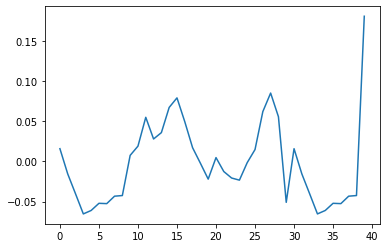

In [14]:
plt.plot(directions)

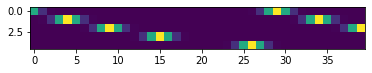

In [15]:
plt.imshow(gt[example].T)

In [16]:
min_dir = np.zeros((nda_vects.shape[0],16,64,64))
max_dir = np.zeros((nda_vects.shape[0],16,64,64))
comb_dir= np.zeros((nda_vects.shape[0],16,64,64))

In [62]:
phases = ['ED', 'MS', 'ES', 'PF', 'MD']
import scipy
import scipy.misc
@interact
def show(e=(0,nda_vects.shape[0]-1),
         t=(0,nda_vects.shape[1]-1),
        cz=(0,nda_vects.shape[2]-1),
        cx=(0,nda_vects.shape[3]-1),
        cy=(0,nda_vects.shape[4]-1),
         show_diffs=False,
        show_norm=False,
        show_dir_heatmap=False,
         show_angles=False,
        mask=False,
        msk_t=0.0,
        dif_t='0.0',
        msk_diff=False):
    
    dif_t = float(dif_t)
    ct = np.array([cz,cy,cx])
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
    
    # focus point C
    dim = np.array([16,64,64])
    idx = get_idxs_tf(dim)
    c = get_focus_tf(ct,dim)
    centers = c - idx
    centers_tensor = centers[tf.newaxis, ...]
    
    # directions according to x,y,z voxels
    heatmap = comb_dir[e,cz]
    ind = np.where(heatmap==np.max(heatmap)) 
    ind_min = np.where(min_dir[e,cz]==np.min(min_dir[e,cz]))
    ind_max = np.where(max_dir[e,cz]==np.max(max_dir[e,cz]))
    
    # norm
    norm = np.linalg.norm(nda_vects[e,t:t+1,...],axis=-1)
    norm_nda = clip_quantile(norm, 0.99)
    norm_nda = minmax_lambda([norm_nda,0,1])
    norm_msk = minmax_lambda([np.max(norm_nda, axis=0),0,1])
    norm_msk = (norm_msk>=msk_t).astype(np.float32)[np.newaxis,...]
    if mask:norm = norm * norm_msk
        
    # diff
    diff_temp = np.abs(mov[e,t,cz,...,0] - mov[e,t+1,cz,...,0])
    mov_temp = mov[e,t,cz,...,0]
    if msk_diff: mov_temp = mov_temp * (diff_temp>=dif_t).astype(np.float32)
    
    print('max diff of {} at y,x: {}'.format(np.max(heatmap), ind))
    print(ind[1][0],ind[0][0])
    im = ax1.imshow(mov_temp, cmap='gray',origin='lower')
    ax1.scatter(ind_min[1][0],ind_min[0][0], label='min',c='orange', marker='<')
    ax1.scatter(ind_max[1][0],ind_max[0][0], label='max',c='orange', marker='o')
    ax1.scatter(ind[1][0],ind[0][0], label='com',c='red', marker='o')
    ax1.scatter(cx,cy, c='pink', marker='o')
    ax1.legend()
    if show_dir_heatmap: 
        im = ax1.imshow(minmax_lambda([comb_dir[e,cz],0,1]), alpha=0.6,origin='lower')
    if show_norm: 
        im = ax1.imshow(np.max(norm[:,cz,...], axis=0), origin='lower', alpha=0.6, cmap='hot')
        
    if show_angles:
        temp = np.max(angles[e,:,cz,...,0], axis=0) + np.min(np.abs(angles[e,:,cz,...,0]), axis=0)
        if mask: temp = temp * norm_msk[0][cz]
        im = ax1.imshow(temp, origin='lower', alpha=0.6, cmap='hot')
        
    if show_diffs:
        print('|t-t+1| {}'.format(diff_temp.mean()))
        if mask: diff_temp = diff_temp * norm_msk[0][cz]
        im = ax1.imshow(diff_temp, origin='lower', alpha=0.6, cmap='hot')
    fig.colorbar(im, orientation='horizontal')
    
    # direction
    dir_ = get_angle_np(nda_vects[e,...],centers_tensor)[...,0]
    if mask: dir_ = dir_*norm_msk
    # direction mean
    dir_ = np.mean(dir_,axis=(1,2,3))
    print(abs(min(dir_)) + max(dir_))
    ax2.imshow(gt[e].T)
    ax2.set_yticks(range(len(phases)), minor=False)
    ax2.set_yticklabels(phases, rotation=0)
    ax3 = ax2.twinx()
    ax3.plot(dir_, c = 'red')
    ax3.set_ylim([-1,1])
    
    plt.show()

interactive(children=(IntSlider(value=49, description='e', max=98), IntSlider(value=19, description='t', max=3…

In [18]:
# b,t,z,x,y
import concurrent
from concurrent.futures import as_completed
from time import time
from src.data.Preprocess import clip_quantile

def helper(c_t, e,cz,cy,cx):
    #print(cx,cy)
    # focus point C
    ct = np.array([cz,cy,cx])
    dim = np.array([16,64,64])
    idx = get_idxs_tf(dim)
    c = get_focus_tf(ct,dim)
    centers = c - idx
    centers_tensor = centers[tf.newaxis, ...]

    # direction
    directions = get_angle_np(c_t,centers_tensor)[...,0]
    
    # mask v_t by a threshold norm
    norm_nda = np.linalg.norm(c_t, axis=-1)
    norm_nda = clip_quantile(norm_nda, 0.99)
    norm_nda = minmax_lambda([norm_nda,0,1])
    norm_msk = minmax_lambda([np.max(norm_nda, axis=1),0,1])
    norm_msk = (norm_msk>=0.5).astype(np.float32)[np.newaxis,...] # this could be used to mask v_t by a threshold norm
    directions = directions * norm_msk
    

    # direction mean
    directions = np.mean(directions,axis=(2,3,4))
    min_d = np.min(directions, axis=1)
    max_d = np.max(directions, axis=1)
    comb_d = abs(min_d) + abs(max_d)
    return ct, e, min_d, max_d, comb_d
    

futures = set()
#e = 1
window = 1
cz = 0
t0 = time()
with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
    for e in range(0,nda_vects.shape[0]-1,window):
        for cz in range(0,nda_vects.shape[2],2):
            for cx in range(0,nda_vects.shape[3],8):
                for cy in range(0,nda_vects.shape[4],8):
                    futures.add(executor.submit(helper, nda_vects[e:e+window], e,cz,cy,cx))
                    #print(cx,cy)
        print('patient: {}'.format(e))
print('all threads started : {}'.format(time()- t0))                            

patient: 0
patient: 1
patient: 2
patient: 3
patient: 4
patient: 5
patient: 6
patient: 7
patient: 8
patient: 9
patient: 10
patient: 11
patient: 12
patient: 13
patient: 14
patient: 15
patient: 16
patient: 17
patient: 18
patient: 19
patient: 20
patient: 21
patient: 22
patient: 23
patient: 24
patient: 25
patient: 26
patient: 27
patient: 28
patient: 29
patient: 30
patient: 31
patient: 32
patient: 33
patient: 34
patient: 35
patient: 36
patient: 37
patient: 38
patient: 39
patient: 40
patient: 41
patient: 42
patient: 43
patient: 44
patient: 45
patient: 46
patient: 47
patient: 48
patient: 49
patient: 50
patient: 51
patient: 52
patient: 53
patient: 54
patient: 55
patient: 56
patient: 57
patient: 58
patient: 59
patient: 60
patient: 61
patient: 62
patient: 63
patient: 64
patient: 65
patient: 66
patient: 67
patient: 68
patient: 69
patient: 70
patient: 71
patient: 72
patient: 73
patient: 74
patient: 75
patient: 76
patient: 77
patient: 78
patient: 79
patient: 80
patient: 81
patient: 82
patient: 83
pa

In [19]:
for i, future in enumerate(as_completed(futures)):
    ct,e, min_d,max_d,comb_d = future.result()
    cz,cy,cx = ct
    min_dir[e:e+window,cz,cy,cx] = min_d
    max_dir[e:e+window,cz,cy,cx] = max_d
    comb_dir[e:e+window,cz,cy,cx] = comb_d

In [20]:
len(futures)

50176

In [31]:
e = 0
angles = []
for e in range(nda_vects.shape[0]):
    angles_t = []
    for t in range(nda_vects.shape[1]-2):
        angles_t.append(get_angle_np(nda_vects[e,t], nda_vects[e,t+1]))
    angles.append(np.stack(angles_t, axis=0))
angles = np.stack(angles, axis=0)

In [36]:
angles.shape

(99, 38, 16, 64, 64, 1)

In [22]:
np.save('data/predicted/min_max_comb_direction_per_voxel_acdc_roll2lv.npz',np.stack([min_dir,max_dir, comb_dir]))

In [17]:
vects_stacked = np.broadcast_to(nda_vects[:e],shape=(centers_stacked.shape[0],40,16,64,64,3))
vects_stacked.shape

(64, 40, 16, 64, 64, 3)

In [18]:
directions = get_angle_tf(vects_stacked.astype(np.float16),centers_stacked.astype(np.float16))[...,0]